## Imports

In [2]:
import os
import pickle
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from PIL import Image  # Load img
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from nltk.translate.bleu_score import corpus_bleu
import torch.backends.cudnn as cudnn
from collections import Counter
import nltk
from nltk.translate.bleu_score import SmoothingFunction
from collections import Counter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install rouge

from rouge import Rouge


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Paths

In [5]:
dataset_path = '/kaggle/input/flickr-image-dataset/flickr30k_images'
images_folder = os.path.join(dataset_path, 'flickr30k_images')
texts = os.path.join(dataset_path, 'results.csv')

## Transform

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Vocabulary Class

In [7]:
class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")


    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}

        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}

        self.freq_threshold = freq_threshold



    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(str(text))]

    def build_vocab(self, sentence_list):
        frequencies = Counter()

        #staring index 4
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(str(text))
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]


## Creat Dataset Class

In [8]:
class FlickrDataset(Dataset):
    """
    FlickrDataset
    """
    def __init__(self,root_dir,caption_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        # self.df = pd.read_csv(caption_file, delimiter = '|')
        self.df = caption_file
        self.transform = transform

        #Get image and caption colum from the dataframe
        self.imgs = self.df["image_name"]
        self.captions = self.df[" comment"]

        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)

        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

## Collate Class

In [9]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)

        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

## Create Dataloader 

In [10]:
def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):
    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return data_loader

## Show Image

In [11]:
def show_image(img, title=None):

    #unnormalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

    img = img.numpy().transpose((1, 2, 0))


    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

## Create Train Val Test

In [12]:
captions_file = pd.read_csv(texts, delimiter='|')

total_groups = len(captions_file) // 5

# Create a column to represent the group number for each row
captions_file['image_group'] = np.repeat(np.arange(total_groups), 5)[:len(captions_file)]

# Shuffle the groups randomly
shuffled_groups = np.random.permutation(captions_file['image_group'].unique())

# Split the groups into train, validation, and test sets
train_groups = shuffled_groups[:int(0.7 * len(shuffled_groups))]
val_groups = shuffled_groups[int(0.7 * len(shuffled_groups)):int(0.85 * len(shuffled_groups))]
test_groups = shuffled_groups[int(0.85 * len(shuffled_groups)):]

# Create train, validation, and test sets based on the selected groups
train_captions = captions_file[captions_file['image_group'].isin(train_groups)]
val_captions = captions_file[captions_file['image_group'].isin(val_groups)]
test_captions = captions_file[captions_file['image_group'].isin(test_groups)]

# Remove the temporary 'image_group' column
train_captions = train_captions.drop('image_group', axis=1)
val_captions = val_captions.drop('image_group', axis=1)
test_captions = test_captions.drop('image_group', axis=1)

train_captions.reset_index(drop=True, inplace=True)
val_captions.reset_index(drop=True, inplace=True)
test_captions.reset_index(drop=True, inplace=True)

# Verify the lengths of each subset
print(f"Train set length: {len(train_captions)}")
print(f"Validation set length: {len(val_captions)}")
print(f"Test set length: {len(test_captions)}")

Train set length: 111240
Validation set length: 23835
Test set length: 23840


In [13]:
trainset =  FlickrDataset(root_dir = images_folder, caption_file = train_captions, transform=transform)
valset =  FlickrDataset(root_dir = images_folder, caption_file = val_captions, transform=transform)
testset =  FlickrDataset(root_dir = images_folder, caption_file = test_captions, transform=transform)
# dataset = FlickrDataset(root_dir = images_folder, caption_file = captions_file, transform=transform)

#writing the dataloader
trainloader = get_data_loader(
    dataset=trainset, batch_size=256, num_workers=1, shuffle=True,
    # batch_first=False
)

valloader = get_data_loader(
    dataset=valset, batch_size=256, num_workers=1, shuffle=True,
    # batch_first=False
)

testloader = get_data_loader(
    dataset=testset, batch_size=256, num_workers=1, shuffle=True,
    # batch_first=False
)


## Model Classes

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.mean(dim=(2, 3))  # Global average pooling
        return features


In [15]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()

        # Save the model parameters
        self.vocab_size = vocab_size
        self.decoder_dim = decoder_dim

        self.embedding = nn.Embedding(vocab_size, embed_size)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.rnn_cell = nn.RNNCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)

        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)

    def forward(self, features, captions):
        # Vectorize the captions
        embeds = self.embedding(captions)

        # Initialize RNN state
        h = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        # Get the sequence length to iterate
        seq_length = len(captions[0]) - 1  # Exclude the last one
        batch_size = captions.size(0)

        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)

        for s in range(seq_length):
            rnn_input = torch.cat((embeds[:, s], features), dim=1)
            h = self.rnn_cell(rnn_input, h)

            output = self.fcn(self.drop(h))

            preds[:, s] = output

        return preds

    def generate_caption(self, features, max_len=20, vocab=None):
        # Inference part
        # Given the image features, generate the captions

        batch_size = features.size(0)
        h = self.init_hidden_state(features)  # (batch_size, decoder_dim)

        # Starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        captions = []

        for i in range(max_len):
            rnn_input = torch.cat((embeds[:, 0], features), dim=1)
            h = self.rnn_cell(rnn_input, h)
            output = self.fcn(self.drop(h))
            output = output.view(batch_size, -1)

            # Select the word with the most value
            predicted_word_idx = output.argmax(dim=1)

            # Save the generated word
            captions.append(predicted_word_idx.item())

            # End if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break

            # Send the generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        # Convert the vocab idx to words and return the sentence
        return [vocab.itos[idx] for idx in captions]

    def init_hidden_state(self, encoder_out):
        # mean_encoder_out = encoder_out.mean(dim=1)
        mean_encoder_out = encoder_out
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        return h

    def compute_bleu_score(self, features, captions, vocab_ref, vocab_gen):

        # Generate captions using existing function
        generated_captions = self.generate_caption(features, max_len=20, vocab=vocab_gen)
        references = [[vocab_ref.itos[idx] for idx in caption[1:-1]] for caption in captions.tolist()]
        references = [[word for word in sublist if word != '<PAD>'] for sublist in references]

        # BLEU score
        smoothie = SmoothingFunction().method4
        bleu_score = corpus_bleu(references, [generated_captions], smoothing_function=smoothie, weights=(0.5, 0.5))

        # ROUGE-N score
        rouge = Rouge()
        rouge_n_score = rouge.get_scores(" ".join(generated_captions), " ".join(references[0]), avg=True)

        return bleu_score, rouge_n_score



In [16]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(trainset.vocab),
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

## Initialize Model

In [21]:
#Hyperparams
embed_size=300
vocab_size = len(trainset.vocab)
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4

#init model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = EncoderDecoder(
    embed_size=300,
    vocab_size = len(trainset.vocab),
    encoder_dim=2048,
    decoder_dim=512
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=trainset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [22]:
from tqdm import tqdm

num_epochs = 10
train_losses = []
val_losses = []
bleu_scores = []
rouge_1s = []
rouge_2s = []
rouge_ls = []

best_bleu_score = 0
best_rouge_score = 0
patience = 7
counter = 0

for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for idx, (image, captions) in enumerate(tqdm(iter(trainloader), desc=f'Epoch {epoch}/{num_epochs}', unit='batch')):
        image, captions = image.to(device), captions.to(device)
        optimizer.zero_grad()
        outputs = model(image, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    blue_s = 0
    rouge_1 = 0
    rouge_2 = 0
    rouge_l = 0
    for idx, (image, captions) in enumerate(tqdm(iter(valloader), desc=f'Validation', unit='batch')):
        image, captions = image.to(device), captions.to(device)
        outputs = model(image, captions)
        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        running_val_loss += loss.item()

        features = model.encoder(image)  
        for i in range(features.size(0)):
            single_feature = features[i].unsqueeze(0)  
            single_caption = captions[i].unsqueeze(0)  
            bleu_score, rouge_score = model.decoder.compute_bleu_score(single_feature, single_caption, vocab_ref=valset.vocab, vocab_gen=trainset.vocab)
            blue_s = blue_s + bleu_score
            rouge1 = rouge_score['rouge-1']['f']
            rouge2 = rouge_score['rouge-2']['f']
            rougel = rouge_score['rouge-l']['f']
            rouge_1 = rouge_1 + rouge1
            rouge_2 = rouge_2 + rouge2
            rouge_l = rouge_l + rougel
    
    blue_s = blue_s / len(valset)
    rouge_1 = rouge_1 / len(valset)
    rouge_2 = rouge_2 / len(valset)
    rouge_l = rouge_l / len(valset)
    bleu_scores.append(blue_s)
    rouge_1s.append(rouge_1)
    rouge_2s.append(rouge_2)
    rouge_ls.append(rouge_l)
    val_loss = running_val_loss / len(valloader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f} ',
          f'Validation Loss: {val_loss:.4f} ',
          f'Rouge 1: {rouge_1:.4f} ',
          f'Rouge 2: {rouge_2:.4f} ',
          f'Rouge L: {rouge_l:.4f} ',
          f'BLEU: {blue_s:.4f}')

    if rouge_1 > best_rouge_score:
        best_rouge_score = rouge_1
        counter = 0
    else:
        counter += 1
        if counter == patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

    model.train()

Validation: 100%|██████████| 94/94 [04:11<00:00,  2.67s/batch]

Epoch 1/10, Training Loss: 4.1121  Validation Loss: 6.0917  Rouge 1: 0.2722  Rouge 2: 0.0739  Rouge L: 0.2599  BLEU: 0.2289



Validation: 100%|██████████| 94/94 [03:57<00:00,  2.53s/batch]

Epoch 2/10, Training Loss: 3.3347  Validation Loss: 6.4969  Rouge 1: 0.3147  Rouge 2: 0.0810  Rouge L: 0.2988  BLEU: 0.2565



Validation: 100%|██████████| 94/94 [03:54<00:00,  2.50s/batch]

Epoch 3/10, Training Loss: 3.0911  Validation Loss: 6.8235  Rouge 1: 0.3283  Rouge 2: 0.0849  Rouge L: 0.3103  BLEU: 0.2624



Validation: 100%|██████████| 94/94 [03:43<00:00,  2.38s/batch]

Epoch 4/10, Training Loss: 2.9490  Validation Loss: 6.9691  Rouge 1: 0.3405  Rouge 2: 0.0894  Rouge L: 0.3219  BLEU: 0.2702



Validation: 100%|██████████| 94/94 [03:47<00:00,  2.42s/batch]

Epoch 5/10, Training Loss: 2.8507  Validation Loss: 7.0825  Rouge 1: 0.3469  Rouge 2: 0.0913  Rouge L: 0.3277  BLEU: 0.2726



Validation: 100%|██████████| 94/94 [03:55<00:00,  2.51s/batch]

Epoch 6/10, Training Loss: 2.7752  Validation Loss: 7.1124  Rouge 1: 0.3363  Rouge 2: 0.0905  Rouge L: 0.3165  BLEU: 0.2605



Validation: 100%|██████████| 94/94 [03:47<00:00,  2.42s/batch]

Epoch 7/10, Training Loss: 2.7151  Validation Loss: 7.2002  Rouge 1: 0.3497  Rouge 2: 0.0927  Rouge L: 0.3310  BLEU: 0.2748



Validation: 100%|██████████| 94/94 [03:58<00:00,  2.54s/batch]

Epoch 8/10, Training Loss: 2.6626  Validation Loss: 7.2298  Rouge 1: 0.3440  Rouge 2: 0.0925  Rouge L: 0.3239  BLEU: 0.2654



Validation: 100%|██████████| 94/94 [03:50<00:00,  2.45s/batch]

Epoch 9/10, Training Loss: 2.6182  Validation Loss: 7.2814  Rouge 1: 0.3496  Rouge 2: 0.0936  Rouge L: 0.3314  BLEU: 0.2750



Validation: 100%|██████████| 94/94 [04:07<00:00,  2.63s/batch]

Epoch 10/10, Training Loss: 2.5775  Validation Loss: 7.3134  Rouge 1: 0.3410  Rouge 2: 0.0928  Rouge L: 0.3213  BLEU: 0.2624


## Test

In [23]:
# Validation
model.eval()
running_val_loss = 0.0
blue_s = 0
rouge_1 = 0
rouge_2 = 0
rouge_l = 0
for idx, (image, captions) in enumerate(tqdm(iter(testloader), desc=f'Test', unit='batch')):
    image, captions = image.to(device), captions.to(device)
    outputs = model(image, captions)
    targets = captions[:, 1:]
    loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
    running_val_loss += loss.item()

    features = model.encoder(image) 
    for i in range(features.size(0)):
        single_feature = features[i].unsqueeze(0)  
        single_caption = captions[i].unsqueeze(0)  
        bleu_score, rouge_score = model.decoder.compute_bleu_score(single_feature, single_caption, vocab_ref=testset.vocab, vocab_gen=trainset.vocab)
        blue_s = blue_s + bleu_score
        rouge1 = rouge_score['rouge-1']['f']
        rouge2 = rouge_score['rouge-2']['f']
        rougel = rouge_score['rouge-l']['f']
        rouge_1 = rouge_1 + rouge1
        rouge_2 = rouge_2 + rouge2
        rouge_l = rouge_l + rougel

blue_s = blue_s / len(testset)
rouge_1 = rouge_1 / len(testset)
rouge_2 = rouge_2 / len(testset)
rouge_l = rouge_l / len(testset)
val_loss = running_val_loss / len(testloader)
print(
      f'Test Loss: {val_loss:.4f} ',
      f'Rouge 1: {rouge_1:.4f} ',
      f'Rouge 2: {rouge_2:.4f} ',
      f'Rouge L: {rouge_l:.4f} ',
      f'BLEU: {blue_s:.4f}')
model.train();



Test: 100%|██████████| 94/94 [04:24<00:00,  2.81s/batch]

Test Loss: 9.1123  Rouge 1: 0.3412  Rouge 2: 0.0916  Rouge L: 0.3215  BLEU: 0.2627


## Plots and Inference

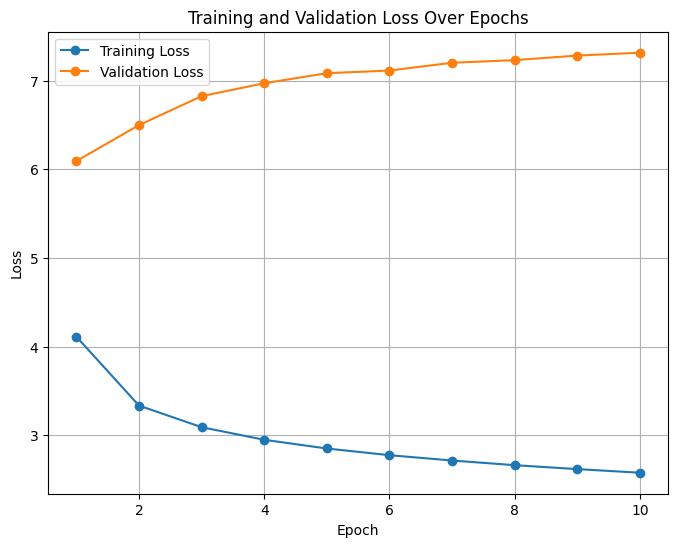

In [24]:
plt.figure(figsize=(8, 6))

# Plot Training and Validation Loss
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')

# Set labels and title
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

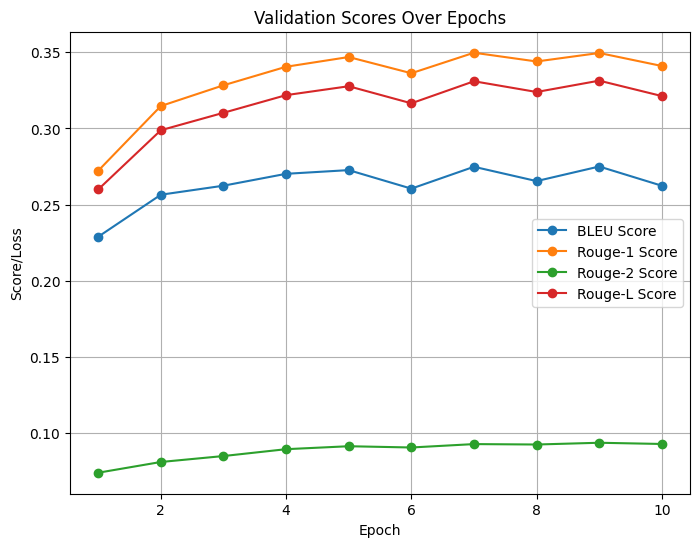

In [25]:

# Plot all scores in one plot
plt.figure(figsize=(8, 6))

# Plot BLEU Score
plt.plot(range(1, num_epochs+1), bleu_scores, label='BLEU Score', marker='o')

# Plot Rouge-1 Score
plt.plot(range(1, num_epochs+1), rouge_1s, label='Rouge-1 Score', marker='o')

# Plot Rouge-2 Score
plt.plot(range(1, num_epochs+1), rouge_2s, label='Rouge-2 Score', marker='o')

# Plot Rouge-L Score
plt.plot(range(1, num_epochs+1), rouge_ls, label='Rouge-L Score', marker='o')

# Set labels and title
plt.title('Validation Scores Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score/Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

  a man in a white shirt and white pants is sitting on a bench . <EOS>


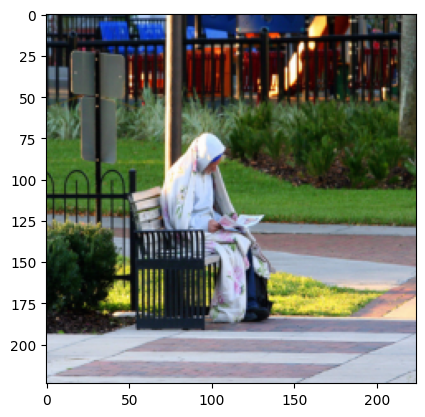

In [26]:
model.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    img,_ = next(dataiter)
    features = model.encoder(img[0:1].to(device))
    caps = model.decoder.generate_caption(features,vocab=trainset.vocab)
    caption = ' '.join(caps)
    print(caption)
    show_image(img[0])

model.train();